# Preparação do estado de bit-phase-flip

In [3]:
'''                                  ReadMe                                                      '''
'''# Nessa célula vamos apenas mudar a função geradora do estado a ser preparado                 '''
'''# Basta alterar a função que gera o estado, nesse caso target_op = init_state_ref(n_qubits, p)'''

from src.vqa_tools import general_vqacircuit_penny 
from src.state_initializer import  init_state_ref,init_state_bpf
from src.generalize import *
from torch import tensor
from numpy import sin,cos,sqrt,outer,zeros, pi
from cmath import exp
import pickle

def pd(theta, phi, p):
    state = zeros(4,dtype=complex)
    state[0] =  cos(theta/2)       
    state[1] = 0
    state[2] = sqrt(p)*exp(1j*phi)*sin(theta/2)
    state[3] = sqrt(p)*exp(1j*phi)*sin(theta/2)
    target_op = outer(state.conj(), state)
    target_op = tensor(target_op)
    return target_op


def pd_ref(p):
    state = zeros(4,dtype=complex)
    state[0] = 1/sqrt(2)
    state[1] = 0
    state[2] = sqrt((1-p)/2)
    state[3] = sqrt(p/2)
    target_op = outer(state.conj(), state)
    target_op = tensor(target_op)
    return target_op

def run_calcs(list_p, epochs):
    coerencias_R = []
    coerencias_L = []
    pretrain = True
    count = 0
    n_qubits = 2
    depht = 3
    _, params, _, _ = start_things(n_qubits, depht)
    for p in list_p:
        print(f'{count} de {len(list_p)}')
        count += 1
        #_, params, _, _ = start_things(n_qubits, depht)
        circuit, _ = general_vqacircuit_penny(params, n_qubits, depht)

        # defina o estado a ser preparado abaixo
        #------------------------------------------------------------
        target_op = pd(pi/2, 0, p)
        #------------------------------------------------------------
        
        qc, qr, params = optmize(epochs, n_qubits, circuit, params, target_op, pretrain, 1000)
        pretrain = False
        rho = tomograph(qc, qr)
        print(rho)
        coerencias_L, coerencias_R = results(rho, coerencias_R, coerencias_L)

    plots(list_p, coerencias_R, coerencias_L)
    save = [list_p, coerencias_R, coerencias_L]
    with open('data/BPFlist_p-coerencias_R-coerencias_L.pkl', 'wb') as f:
        pickle.dump(save, f)
    

0 de 11
[[ 9.98191166e-01+0.00000000e+00j  1.68455198e-02+7.66290526e-03j
  -4.29512476e-03+1.80606187e-02j -1.25328295e-02-7.85182913e-03j]
 [ 1.68455198e-02-7.66290526e-03j  7.91045792e-04+0.00000000e+00j
   4.99721589e-04+4.55866611e-04j -2.46012423e-04-5.89339755e-05j]
 [-4.29512476e-03-1.80606187e-02j  4.99721589e-04-4.55866611e-04j
   7.96042520e-04+0.00000000e+00j -6.91649264e-05+2.31840693e-04j]
 [-1.25328295e-02+7.85182913e-03j -2.46012423e-04+5.89339755e-05j
  -6.91649264e-05-2.31840693e-04j  2.21745950e-04+0.00000000e+00j]]
1 de 11
[[ 8.14594639e-01+0.j          2.68823700e-01+0.02152817j
  -8.17521518e-03-0.0153255j   2.79230279e-01+0.00541436j]
 [ 2.68823700e-01-0.02152817j  8.92832339e-02+0.j
  -3.10291934e-03-0.0048415j   9.22916435e-02-0.00559273j]
 [-8.17521518e-03+0.0153255j  -3.10291934e-03+0.0048415j
   3.70374404e-04+0.j         -2.90419952e-03+0.005199j  ]
 [ 2.79230279e-01-0.00541436j  9.22916435e-02+0.00559273j
  -2.90419952e-03-0.005199j    9.57517522e-02+0.j  

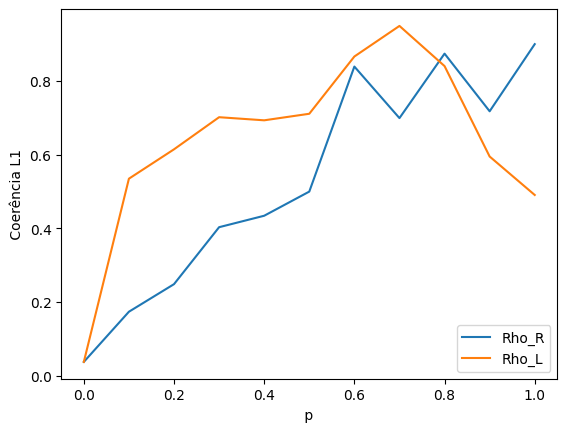

In [4]:
list_p = np.linspace(0,1,11)
run_calcs(list_p, 100)

In [2]:
#import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
#list_p = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
list_p = np.linspace(0,1,4)
n_qubits = 2
depht = 4
coerencias_R = []
coerencias_L = []
for p in list_p:
    print(f'p = {p} de {len(list_p)}')
    n = 3*n_qubits*(1+depht)
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    print(f'LEN PARAMS ={len(params)}')
    circuit, _ = general_vqacircuit_penny(n_qubits, depht)
    target_vector, target_op = init_state_ref(n_qubits, p)
    params, f = train(100, circuit, params, target_op)

    parametros = params.detach().numpy()
    qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)

    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    #rhoA = pTraceR(2, 2, rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)

p = 0.0 de 4
LEN PARAMS =18
0 0.24514102935791005
1 0.07800674438476557
2 0.019501686096191344
3 0.006103515624999965
4 0.016616821289062444
5 0.03021621704101555
6 0.02887344360351555
7 0.02987766265869133
8 0.023507118225097587
9 0.013962745666503854
p = 0.3333333333333333 de 4
LEN PARAMS =18
0 0.8159875869750977
1 0.4606485366821289
2 0.2234039306640625
3 0.07317447662353516
4 0.031937599182128865
5 0.013732910156249948
6 0.014663696289062446
7 0.02232456207275387
8 0.03776645660400382
9 0.060562133789062444
p = 0.6666666666666666 de 4
LEN PARAMS =18
0 0.43580627441406233
1 0.16662979125976554
2 0.02565002441406243
3 0.0012359619140624844
4 0.0023841857910156033
5 0.008606910705566365
6 0.026597023010253833
7 0.04532241821289053
8 0.056777954101562396
9 0.0544748306274413
p = 1.0 de 4
LEN PARAMS =18
0 0.23273086547851551
1 0.13126468658447257
2 0.05044937133789053
3 0.04408359527587886
4 0.02261734008789056
5 0.008789062499999958
6 0.006729125976562464
7 0.002106666564941386
8 0.001

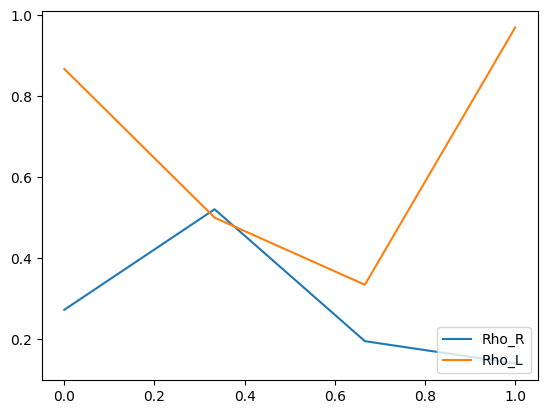

In [3]:
plt.plot(list_p,coerencias_R,label='Rho_R')
plt.plot(list_p,coerencias_L,label='Rho_L')
plt.legend(loc=4)
plt.show()

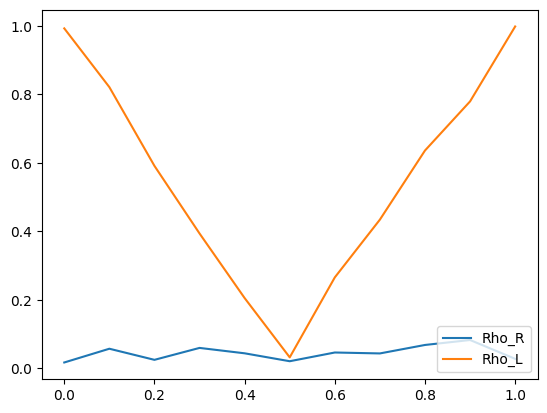

In [ ]:
plt.plot(list_p,coerencias_R,label='Rho_R')
plt.plot(list_p,coerencias_L,label='Rho_L')
plt.legend(loc=4)
plt.show()

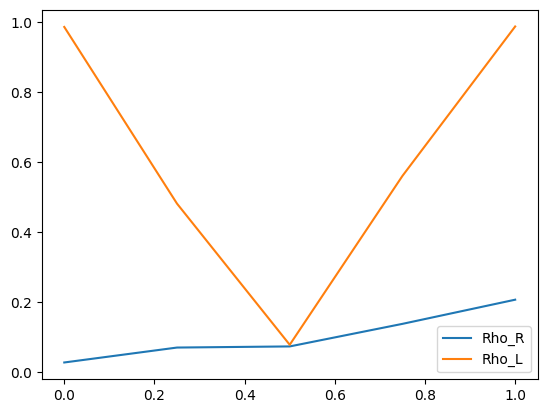

In [8]:
plt.plot(list_p,coerencias_R,label='Rho_R')
plt.plot(list_p,coerencias_L,label='Rho_L')
plt.legend(loc=4)
plt.show()

In [17]:
#import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
list_p = np.linspace(0,1,10)
#list_p = [0,0.25,0.5,0.75,1]
n_qubits = 2
coerencias_R = []
coerencias_L = []
for p in list_p:
    print(f'p = {p} de {len(list_p)}')
    circuit, params = general_vqacircuit_penny(n_qubits, 5)
    target_vector, target_op = init_state_bpf(n_qubits, p)
    best_params, f = train(10, circuit, params, target_op)

    parametros = best_params.detach().numpy()
    qc, qr = general_vqacircuit_qiskit(n_qubits, parametros)
    #qr = QuantumRegister(2); qc = qiskit.QuantumCircuit(qr)
    #print(params.detach().numpy()[0])
    #print(len(parametros))
    #for i in range(0,24,6):
    #    #print(i)
    #    qc.rx(parametros[i],0)
    #    qc.ry(parametros[i+1],0)
    #    qc.rz(parametros[i+2],0)
    #    
    #    qc.rx(parametros[i+3],1)
    #    qc.ry(parametros[i+4],1)
    #    qc.rz(parametros[i+5],1)
    #    if i < 15:
    #        qc.cnot(0,1)
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    #rhoA = pTraceR(2, 2, rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)
    

p = 0.0 de 10
0 0.9670724868774414
1 0.4699745178222656
2 0.060082435607910156
3 0.00390625
4 0.022912025451660156
5 0.12018680572509766
6 0.14804458618164062
7 0.0813140869140625
8 0.037011146545410156
9 0.02203369140625
9 0.02203369140625
p = 0.1111111111111111 de 10
0 0.5252946482764351
1 0.08336904313829215
2 0.009211083989084533
3 0.02115673783384727
4 0.04690683623890825
5 0.042548014793867016
6 0.05054690514081798
7 0.06331645117865678
8 0.04044829768899051
9 0.01432405872109498
9 0.01432405872109498
p = 0.2222222222222222 de 10
0 0.7321981265221114
1 0.1172705756293404
2 0.0026676507643711676
3 0.0036396921416859897
4 0.020081743781949355
5 0.059922960069444586
6 0.05221939086914073
7 0.027417265338662337
8 0.009034898546007015
9 0.000963046226972432
9 0.000963046226972432
p = 0.3333333333333333 de 10
0 0.2803275055355494
1 0.004474878311157168
2 0.0057033962673612
3 0.002368317710028704
4 0.023557053671942704
5 0.0022587246365016796
6 0.0008968777126736555
7 0.0042597717709012

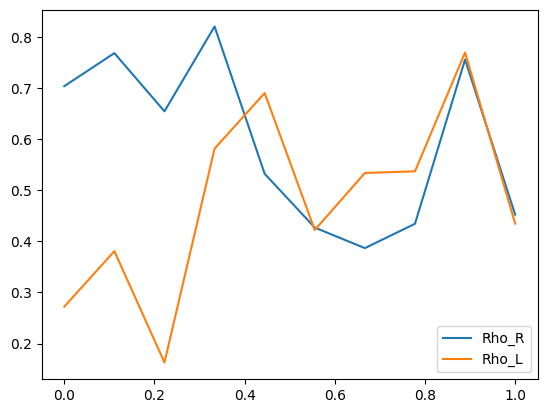

In [18]:
plt.plot(list_p,coerencias_R,label='Rho_R')
plt.plot(list_p,coerencias_L,label='Rho_L')
plt.legend(loc=4)
plt.show()

In [1]:
#from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import sys
import pickle
import os
import cmath
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere


ModuleNotFoundError: No module named 'tools'

In [2]:
import qiskit
from qiskit import *
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from coherence import coh_l1
from pTrace import pTraceR

# pra iniciar ambiente da tomografia
nshots = 8192
IBMQ.save_account('7cc830e0cb005ce6de9caf9c402a1992c5d38d25af4237c19e72a4c58ce204481eb7a0d08b9929e5b5d3028f3146c38d2da8f2eb8db8f6f8b02a97eeb8fbc6de')
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('qasm_simulator')

/tmp/ipykernel_52470/3847348147.py:4: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
configrc.store_credentials:WARNING:2023-02-16 21:57:30,051: Credentials already present. Set overwrite=True to overwrite.


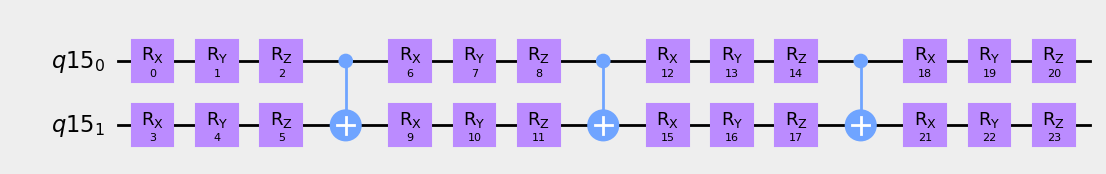

In [39]:
from qiskit import *
import qiskit
def general_vqacircuit_qiskit(n_qubits, params):
    #n = 3*n_qubits*(1+depht) # n=len(params)
    depht = int(len(params)/(3*n_qubits)-1)
    qr = QuantumRegister(n_qubits); qc = qiskit.QuantumCircuit(qr)
    aux = 0
    for j in range(depht+1):
        for i in range(n_qubits):
            qc.rx(params[aux],i)
            aux += 1
            qc.ry(params[aux],i)
            aux += 1
            qc.rz(params[aux],i)
            aux += 1
        if j < depht:
            for i in range(n_qubits-1):
                qc.cnot(i,i+1)
    return qc, qr

n_qubits = 2
params = [i for i in range(0,24)]
qc, qr = general_vqacircuit_qiskit(n_qubits,params)
qc.draw(output='mpl', style={'backgroundcolor': '#EEEEEE'})


30
[0, 1]


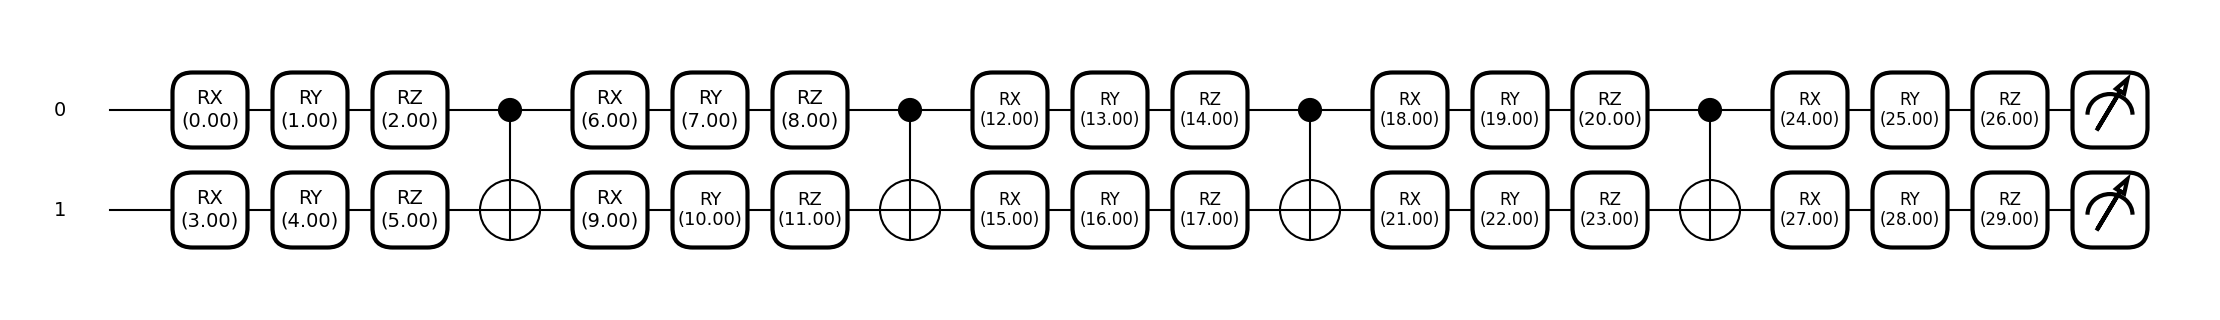

In [32]:
from src.tools import *

def general_vqacircuit_penny(n_qubits, depht=None):
    #n_qubits = 1
    if depht == None:
        depht = n_qubits+1
    n = 3*n_qubits*(1+depht)
    params = random_params(n)
    #params = [i for i in range(0,n)]
    #print(len(params))
    device = get_device(n_qubits)
    @qml.qnode(device, interface="torch")
    def circuit(params, M=None):
        w = [i for i in range(n_qubits)]
        aux = 0
        if n_qubits == 1:
            for j in range(depht+1):
                qml.RX(params[aux], wires=0)
                aux += 1
                qml.RY(params[aux], wires=0)
                aux += 1
                qml.RZ(params[aux], wires=0)
                aux += 1
            return qml.expval(qml.Hermitian(M, wires=w))
        for j in range(depht+1):
            for i in range(n_qubits):
                qml.RX(params[aux], wires=i)
                aux += 1
                qml.RY(params[aux], wires=i)
                aux += 1
                qml.RZ(params[aux], wires=i)
                aux += 1
            if j < depht:
                for i in range(n_qubits-1):
                    qml.CNOT(wires=[i,i+1])
        return qml.expval(qml.Hermitian(M, wires=w))
    return circuit, params
n_qubits = 2
circuit, params = general_vqacircuit_penny(n_qubits,4)
target_vector, target_op = init_state_rsvg(n_qubits)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, target_op)
plt.show()

In [1]:
import numpy as np
from src.tools import *
from pTrace import *
from qiskit import *
import qiskit
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from src.coherence import coh_l1

# Para fazer o processo para cada valor de p
#list_p = np.linspace(0,1,2)
list_p = [0,0.25,0.5,0.75,1]
n_qubits = 2
coerencias_R = []
coerencias_L = []
for p in list_p:
    print(f'p = {p} de {len(list_p)}')
    circuit, params = vqa_bpf(n_qubits)
    target_vector, target_op = init_state_bpf(n_qubits, p)
    best_params, f = train(20, circuit, params, target_op)

    qr = QuantumRegister(2); qc = qiskit.QuantumCircuit(qr)
    #print(params.detach().numpy()[0])
    parametros = best_params.detach().numpy()
    #print(len(parametros))
    for i in range(0,24,6):
        #print(i)
        qc.rx(parametros[i],0)
        qc.ry(parametros[i+1],0)
        qc.rz(parametros[i+2],0)
        
        qc.rx(parametros[i+3],1)
        qc.ry(parametros[i+4],1)
        qc.rz(parametros[i+5],1)
        if i < 15:
            qc.cnot(0,1)
    qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
    nshots = 8192
    job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
    qstf = StateTomographyFitter(job.result(), qstc)
    rho = qstf.fit(method='lstsq')
    rhoA_R = pTraceR_num(2,2,rho)
    rhoA_L = pTraceL_num(2,2,rho)
    #rhoA = pTraceR(2, 2, rho)
    cA_R = coh_l1(rhoA_R)
    cA_L = coh_l1(rhoA_L)
    coerencias_R.append(cA_R)
    coerencias_L.append(cA_L)
    
    

/tmp/ipykernel_9264/2625418797.py:6: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


p = 0 de 5
0 0.7218360900878906
1 0.3364906311035156
2 0.13482666015625
3 0.05133056640625
4 0.0308990478515625
5 0.032993316650390625
6 0.038529396057128906
7 0.041657447814941406
8 0.0478515625
9 0.023807525634765625
10 0.01373291015625
11 0.005222320556640625
12 0.005222320556640625
13 0.005951881408691406
14 0.009159088134765625
15 0.010715484619140625
16 0.008606910705566406
17 0.013504981994628906
18 0.014901161193847656
19 0.011962890625
19 0.011962890625
p = 0.25 de 5
0 0.6811487823724749
1 0.23391014337539684
2 0.011882916092872668
3 0.004377424716949492
4 0.027601733803749157
5 0.0811053663492204
6 0.09276010096073165
7 0.029081240296363907
8 0.004978239536285432
9 0.000263586640357964
10 0.005709543824195828
11 0.0014598518610000441
12 0.0004721283912658595
13 0.0018568187952041817
14 0.011408701539039659
15 0.013363495469093375
16 0.0149309784173966
17 0.0071976333856583015
18 0.00031763315200806456
19 0.0002796798944473341
19 0.0002796798944473341
p = 0.5 de 5
0 0.52258497

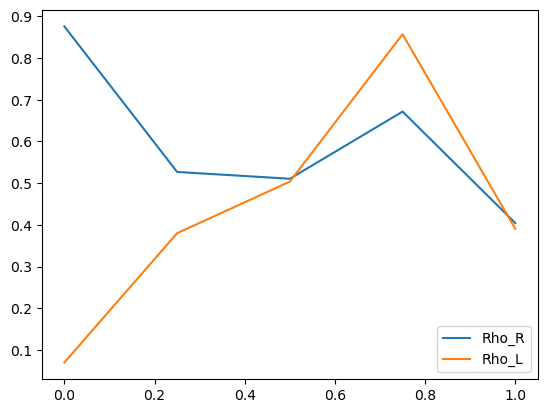

In [2]:
plt.plot(list_p,coerencias_R,label='Rho_R')
plt.plot(list_p,coerencias_L,label='Rho_L')
plt.legend(loc=4)
plt.show()

In [2]:
n_qubits = 2
circuit, params = vqa_bpf(n_qubits)
target_vector, target_op = init_state_bpf(n_qubits, 0.5)
best_params, f = train(10, circuit, params, target_op)


0
6
12
18
0
6
12
18
0 0.6909944993398751
0
6
12
18
0
6
12
18
1 0.23358050488672522
0
6
12
18
0
6
12
18
2 0.027468611210303397
0
6
12
18
0
6
12
18
3 0.0004021987203293613
0
6
12
18
0
6
12
18
4 0.006878889446596353
0
6
12
18
0
6
12
18
5 0.023137959085103906
0
6
12
18
0
6
12
18
6 0.039710445917620615
0
6
12
18
0
6
12
18
7 0.03604005076515831
0
6
12
18
0
6
12
18
8 0.03524857329699104
0
6
12
18
0
6
12
18
9 0.008340004986523592
0
6
12
18
9 0.008340004986523592


In [5]:
with open('params_nqb-2_BPF1.pkl', 'wb') as a:
        pickle.dump(best_params, a)

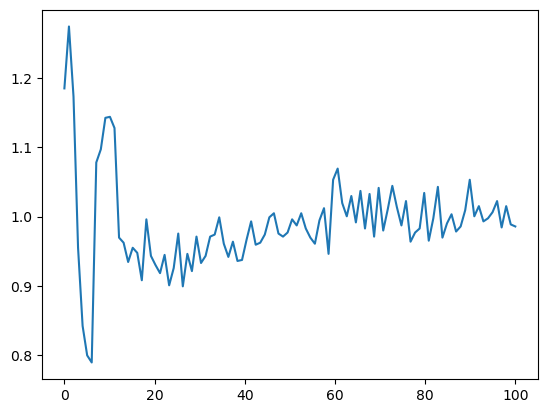

In [7]:
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [ ]:
#from qiskit_experiments.library import StateTomography
#from qiskit.providers.aer import AerSimulator

#beckend = Aer.get_backend('qasm_simulator')

In [4]:
import qiskit
from qiskit import *

nshots = 8192
IBMQ.save_account('7cc830e0cb005ce6de9caf9c402a1992c5d38d25af4237c19e72a4c58ce204481eb7a0d08b9929e5b5d3028f3146c38d2da8f2eb8db8f6f8b02a97eeb8fbc6de')
IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor

configrc.store_credentials:WARNING:2023-02-16 13:50:42,213: Credentials already present. Set overwrite=True to overwrite.


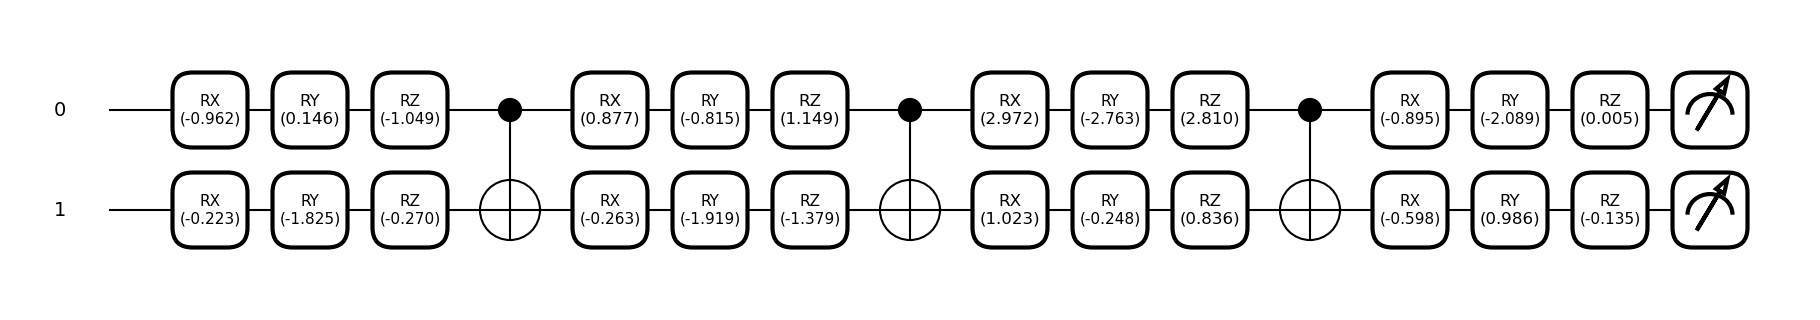

In [5]:
fig, ax = qml.draw_mpl(circuit, decimals=3)(best_params, target_op)
plt.show()

In [5]:
with open('Fidelidades_nqb-2_BPF1.pkl', 'rb') as f:
    best_params = pickle.load(f)
print(best_params)
print(len(best_params))

[0.927734375, 0.855494463683659, 0.8702003958155392, 1.0191127527212536, 0.9517138227461606, 0.9409092496643845, 1.0065191186412212, 0.98227962435546, 1.0187024483354241, 0.9370857539779589]
10


In [6]:

qr = QuantumRegister(2); qc = qiskit.QuantumCircuit(qr)
#print(params.detach().numpy()[0])
parametros = best_params.detach().numpy()
#print(len(parametros))
aux = 0
for i in range(0,24,6):
    #print(i)
    qc.rx(parametros[i],0)
    qc.ry(parametros[i+1],0)
    qc.rz(parametros[i+2],0)
    
    qc.rx(parametros[i+3],1)
    qc.ry(parametros[i+4],1)
    qc.rz(parametros[i+5],1)
    if i < 15:
        qc.cnot(0,1)
print(qc)

         ┌─────────────┐┌─────────────┐┌─────────────┐      ┌─────────────┐»
q3006_0: ┤ Rx(-1.6941) ├┤ Ry(0.99811) ├┤ Rz(0.38481) ├───■──┤ Rx(-1.8857) ├»
         └┬────────────┤├─────────────┤├─────────────┴┐┌─┴─┐├─────────────┤»
q3006_1: ─┤ Rx(-1.682) ├┤ Ry(0.43213) ├┤ Rz(-0.40637) ├┤ X ├┤ Rx(-1.6498) ├»
          └────────────┘└─────────────┘└──────────────┘└───┘└─────────────┘»
«         ┌─────────────┐┌──────────────┐     ┌──────────────┐┌──────────────┐»
«q3006_0: ┤ Ry(0.49786) ├┤ Rz(-0.22203) ├──■──┤ Rx(-0.75343) ├┤ Ry(-0.57589) ├»
«         └┬────────────┤├─────────────┬┘┌─┴─┐├─────────────┬┘└┬────────────┬┘»
«q3006_1: ─┤ Ry(3.6016) ├┤ Rz(0.55605) ├─┤ X ├┤ Rx(-1.5708) ├──┤ Ry(1.7203) ├─»
«          └────────────┘└─────────────┘ └───┘└─────────────┘  └────────────┘ »
«         ┌─────────────┐      ┌──────────┐ ┌──────────────┐┌─────────────┐
«q3006_0: ┤ Rz(0.27613) ├──■───┤ Rx(-2.3) ├─┤ Ry(-0.59026) ├┤ Rz(0.66193) ├
«         └┬────────────┤┌─┴─┐┌┴──────────┴┐├─────────────┬┘└┬─

In [7]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qstc = state_tomography_circuits(qc, [qr[0],qr[1]])
nshots = 8192
job = qiskit.execute(qstc, Aer.get_backend('qasm_simulator'), shots=nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')

rho

/tmp/ipykernel_9902/279195587.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


array([[ 0.23619292+0.j        ,  0.00164284-0.19283577j,
         0.1535461 -0.15495861j, -0.03003643+0.30476647j],
       [ 0.00164284+0.19283577j,  0.16018522+0.j        ,
         0.12866416+0.12690952j, -0.24953351-0.0247586j ],
       [ 0.1535461 +0.15495861j,  0.12866416-0.12690952j,
         0.20443277+0.j        , -0.22193469+0.17796983j],
       [-0.03003643-0.30476647j, -0.24953351+0.0247586j ,
        -0.22193469-0.17796983j,  0.39918909+0.j        ]])

In [8]:
def pTraceR(dl, dr, rhoLR):
    # Returns the right partial trace over the 'right' subsystem of rhoLR
    rhoA = np.zeros((dl, dl), dtype=complex)
    for j in range(0, dl):
        for k in range(j, dl):
            for l in range(0, dr):
                rhoA[j][k] += rhoLR[j*dr+l][k*dr+l]
        if j != k:
            rhoA[k][j] = np.conj(rhoA[j][k])
    return rhoA

In [9]:
rhoA = pTraceR(2, 2, rho)
rhoA

In [12]:
import math
def coh_l1(rho):  # normalized to [0,1]
    d = rho.shape[0]
    coh = 0.0
    for j in range(0, d-1):
        for k in range(j+1, d):
            coh += math.sqrt((rho[j][k].real)**2.0 + (rho[j][k].imag)**2.0)
    return 2.0*coh/(d-1)
cA = coh_l1(rhoA)
cA

0.40748919009876183

In [4]:
theta = np.linspace(0,np.pi,3)
phi = np.linspace(0,np.pi/2,3)

n = 10
n_qubits = 2
fidelidades = []
pes = np.linspace(0,1,n)
for i in range(0, n):
    circuit, params = vqa(n_qubits)
    target_vector, target_op = init_state_bpf(n_qubits, pes[i])
    best_params, f = train(15, circuit, params, target_op)
    fidelidades.append(f[-1])
    with open('Fidelidades_nqb-2_BPF1.pkl', 'wb') as a:
        pickle.dump(fidelidades, a)

0 0.8019342422485352
1 0.5595741271972656
2 0.3142127990722656
3 0.1341104507446289
4 0.0710763931274414
5 0.038529396057128906
6 0.020328521728515625
7 0.011962890625
8 0.005364418029785156
9 0.005222320556640625
10 0.006257057189941406
11 0.004281044006347656
12 0.002780914306640625
13 0.004029273986816406
14 0.006890296936035156
14 0.006890296936035156
0 0.8566724702286012
1 0.4403098056526978
2 0.15728251109873542
3 0.0519254597707173
4 0.06638103638885748
5 0.053291235437159745
6 0.08723657758714508
7 0.06235286248592883
8 0.06235286248592883
9 0.038072063371966336
10 0.03924281638305612
11 0.025405915158662865
12 0.02263828808219481
13 0.018650248463363498
14 0.0145652710937793
14 0.0145652710937793
0 0.43186350771561444
1 0.15602020557962967
2 0.04137508943328821
3 0.035450685478142854
4 0.035450685478142854
5 0.02692332324286987
6 0.016071792572261625
7 0.024341158830895982
8 0.016587188842029876
9 0.014091548013954465
10 0.01093928104186512
11 0.013150230047260335
12 0.0138531

In [8]:
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

TypeError: object of type '_io.BufferedReader' has no len()

10


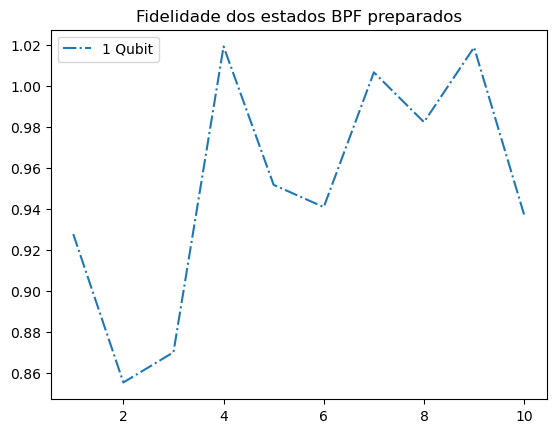

In [7]:
with open('Fidelidades_nqb-2_BPF1.pkl', 'rb') as f:
    y1 = pickle.load(f)
print(len(y1))
size = len(y1)
x = np.linspace(1, size, size)
plt.plot(x, y1[0:size], label='1 Qubit', linestyle="dashdot")
# plt.plot(x, y2[0:size], label='2 Qubit', linestyle=":")
# plt.plot(x, y3[0:size], label='3 Qubit', linestyle="--")
# plt.plot(x, y4[0:size], label='4 Qubit')
plt.title('Fidelidade dos estados BPF preparados')
#plt.ylim(0.95, 1.01)
plt.legend()
plt.show()

Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


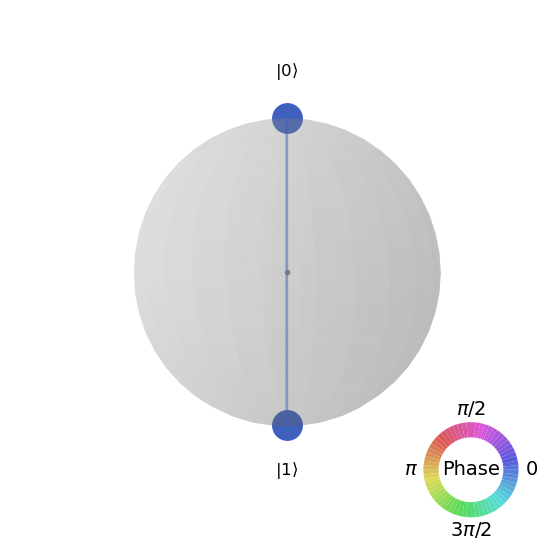

In [22]:
# TESTE COM O QISKIT
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
sv=Statevector.from_label('+')
print(sv)
plot_state_qsphere(sv)

[0.70710678+0.j 0.70710678+0.j]


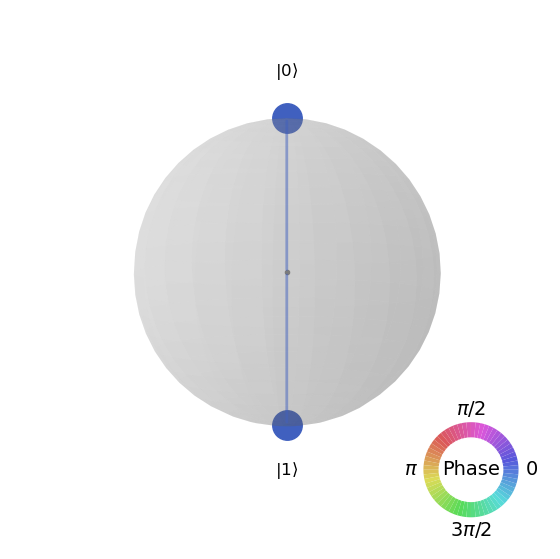

In [13]:
def general_state(theta, phi):
    state = np.zeros(2,dtype=complex)
    state[0] = np.cos(theta/2)
    state[1] = cmath.exp(1j*phi)*np.sin(theta/2)
    return state
print(general_state(np.pi/2,0))
sv=Statevector(general_state(np.pi/2,0))
plot_state_qsphere(sv)

In [9]:
import numpy as np
print(np.exp(np.float128(-10))) 
print(np.exp(np.float128(-10000)))

4.5399929762484851536e-05
1.1354838653147360985e-4343


In [5]:
def bpf(theta, phi, p):
    state = np.zeros(4,dtype=complex)
    state[0] = np.sqrt(1-p)*np.cos(theta/2)
    state[1] = cmath.exp(1j*phi)*np.sin(theta/2)
    state[2] = 1j*np.sqrt(p)*(-1)*cmath.exp(1j*phi)*np.sin(theta/2)
    state[3] = 1j*np.sqrt(p)*np.cos(theta/2)
    return state

print(bpf(np.pi/4,0,0.5))
#print(np.outer(bpf(np.pi/2,np.pi/4,0.5),bpf(np.pi/2,np.pi/4,0.5)))


[0.65328148+0.j         0.38268343+0.j         0.        -0.27059805j
 0.        +0.65328148j]


In [9]:
op = bpf(np.pi/1.5,0,0.5)
sv=Statevector(op)
plot_state_qsphere(sv)

QiskitError: 'Invalid input: not a vector or column-vector.'

NameError: name 'init_state_bpf' is not defined